In [ ]:
# default_exp laziness

In [ ]:
#hide
from numpy.lib.function_base import average
from nbdev.showdoc import *
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Laziness Curvature
> Compute graph curvature via the laziness of random walks, via a powered diffusion matrix

This method currently performs well *as long as* the number of steps of diffusion is set sufficiently high. For low step values, it is prone to over-emphasize density variations.

For datasets in which visualization is possible, you can manually increase the number of diffusion steps until the results appear smooth.

In [ ]:
# export
import numpy as np
def curvature(P, diffusion_powers=8, aperture = 20, smoothing=1, verbose = False, return_density = False, dynamically_adjusting_neighborhood = False, precomputed_powered_P = None):
    # the aperture sets the size of the one-hop neighborhood 
    # the aperture parameter is the average number of neighbors to include, based off of the sorted diffusion values
    # Set thresholds as the kth largest diffusion value, presumed to be held by the kth nearest neighbor.
    thresholds = np.partition(P,-aperture)[:,-aperture]
    # thresholds = np.sort(P)[:,-aperture] 
    if verbose: print(thresholds)
    if dynamically_adjusting_neighborhood:
        P_thresholded = (P >= thresholds[:,None]).astype(int)
    else:
        P_threshold = np.mean(thresholds) # TODO could also use min
        P_thresholded = (P >= P_threshold).astype(int)
        if verbose: print("Derived threshold ",P_threshold)

    if verbose: print(np.sum(P_thresholded,axis=1))
    if verbose: print("Performing matrix powers...")
    
    if precomputed_powered_P is not None:
        P_powered = precomputed_powered_P
    else:
        P_powered = np.linalg.matrix_power(P,diffusion_powers)
    # take the diffusion probs of the neighborhood
    near_neighbors_only = P_powered * P_thresholded
    laziness_aggregate = np.sum(near_neighbors_only,axis=1)
    laziness = laziness_aggregate
    if smoothing: # TODO there are probably more intelligent ways to do this smoothing
        # Local averaging to counter the effects local density
        if verbose: print("Applying smoothing...")
        smoothing_P_powered = np.linalg.matrix_power(P,smoothing)
        average_laziness = smoothing_P_powered @ laziness_aggregate[:,None]
        average_laziness = average_laziness.squeeze()
        laziness = average_laziness
    if return_density:
        # compute sums of neighbors taken into consideration
        ones_matrix = np.ones_like(P_thresholded)
        ones_remaining = ones_matrix * P_thresholded
        local_density = np.sum(ones_remaining,axis=1)
        return laziness, local_density
    return laziness

# Examples

## Torus with Adaptive Kernel

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix
X = torus(n=5000)
P = DiffusionMatrix(X,kernel_type="adaptive",k=20)

Distance to kth neighbors [0.42894022 0.38871225 0.35581591 ... 0.38957046 0.48091129 0.38540188]


Let's visualize a single diffusion here:

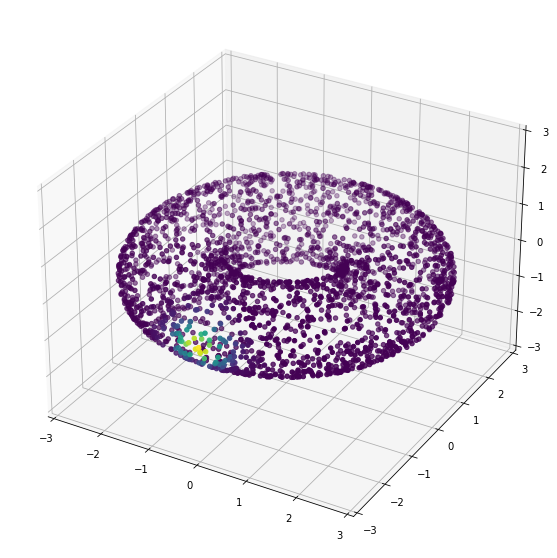

In [ ]:
from diffusion_curvature.core import plot_3d
plot_3d(X,P[0])

Looks fairly good. It's too small to bleed across the torus, so it should emphasize the step-wise nature of the random-walk laziness calculation.

In [ ]:
ks = curvature(P,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False)

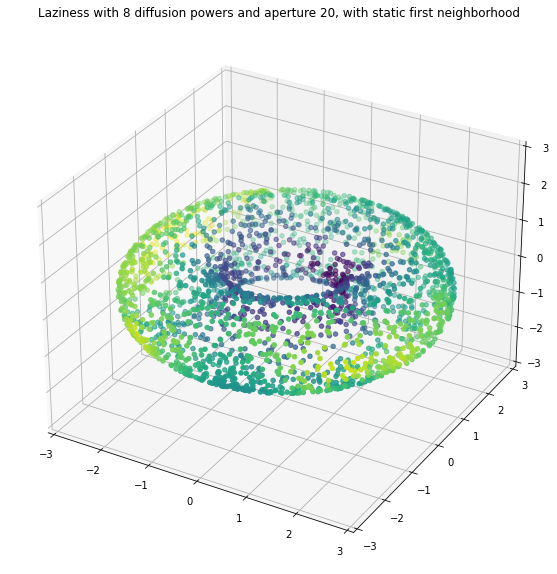

In [ ]:
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood")

In [ ]:
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood",use_plotly=True)

As we can see, the general trend follows curvature well. There are some density variations along the outer rim of the torus, which result in regions of slightly higher laziness.

Note that the above uses 1 step of smoothing (currently implemented by multiplying the raw laziness values with the diffusion matrix, as a weighted knn averaging operation.)

Without this smoothing, the laziness looks like this:

In [ ]:
ks = curvature(P,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=None)
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood and NO smoothing",use_plotly=True)


This emphasizes that the density variations still contribute to significant local variations in the reported curvature. 

Let's try a means of addressing this via a fancier kernel.

## Torus with Adaptive Anisotropic Kernel

Distance to kth neighbors [0.44229526 0.46031858 0.44299981 ... 0.49866228 0.50956835 0.47008406]


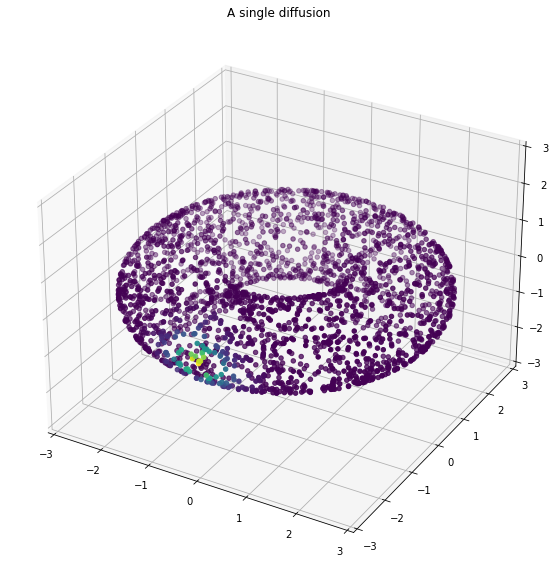

In [ ]:
from diffusion_curvature.datasets import torus
from diffusion_curvature.core import DiffusionMatrix
X = torus(n=5000)
P_anis = DiffusionMatrix(X,kernel_type="adaptive anisotropic",k=20)
plot_3d(X,P_anis[0],"A single diffusion")

Without smoothing, here's how this looks:

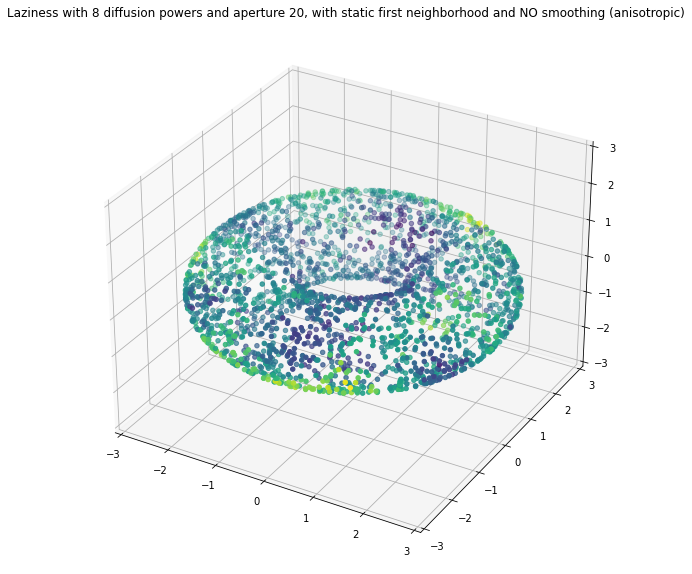

In [ ]:
ks = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=None)
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood and NO smoothing (anisotropic)")

In [ ]:
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood and NO smoothing (anisotropic)",use_plotly=True)

Making the adaptive kernel anisotropic actually seems to have worsened the impact of density.

Here's how it looks with smoothing.

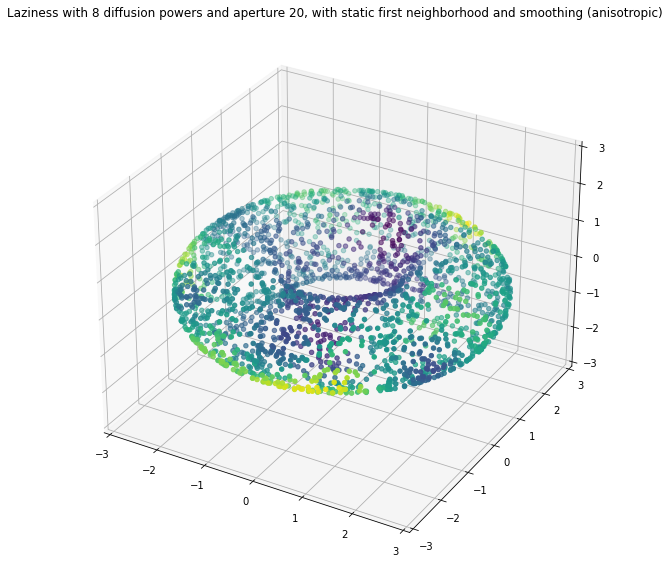

In [ ]:
ks = curvature(P_anis,diffusion_powers=8,aperture=20,dynamically_adjusting_neighborhood=False,smoothing=1)
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood and smoothing (anisotropic)")

In [ ]:
plot_3d(X,ks,title="Laziness with 8 diffusion powers and aperture 20, with static first neighborhood and smoothing (anisotropic)",use_plotly=True)

It's wild! Making the adaptive kernel anisotropic appears to hiner the avoidance of density.